# ECE457A: Assignment 4
**Logan Hartford**

## Problem 1
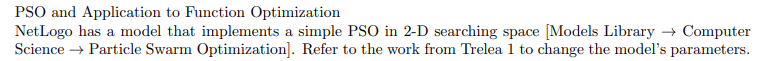

### Deliverable A
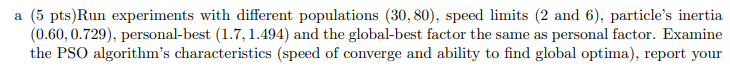

#### NetLogo Observations

**Baseline**
- With all parameters set to their first value.
- Swarm appears to converge quickly but does not always find the optimal solution.
- Usually converges into a single ssoc_coeffarm where several particles will be one top of eachother at the local optimum which the other are sort of oscillating in place around them.

**Increasing Population Size**
- More often finds the optimal solution
- Still has occurances where the swarm doesn't find the solution, and doesn't continue to explore.
- More likely to coverge on multiple locations at one.
- Converges more quickly.

**Increasing Speed Limits**
- Swarm converges much more quicly.
- Pattern of convergence seems less repative/stable.
- Still prone to getting stuck in t local optimia without exploration.

**Increasing Intertia**
- Slower to converge, but also more likely to be able to break out of a pattern of convergence it seems.

**Decreasing Attraction to Best**
- Not a terribly noticable difference form baseline.
- When swarms converge on local optima, they maybe seem to form a larger cluster.

### Deliverable B
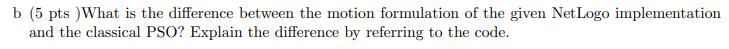

Looking at thge NetLogo code, I was able to identify 5 differences from a classic PSO implementation:

1. **Inertia**
- In NetLogo, the velocity is multiplied by `particle-inertia` and further scaled by `(1 - particle-inertia)` in the personal and global best updates. 
- In classical PSO, a fixed inertia weight (w) is used without additional scaling.

```Python
# NetLogo Implementation
set vx particle-inertia * vx
set vy particle-inertia * vy
set vx vx + (1 - particle-inertia) * attraction-to-personal-best * (random-float 1.0) * dist * dx
set vy vy + (1 - particle-inertia) * attraction-to-personal-best * (random-float 1.0) * dist * dy

# Classical PSO Implementation
v[i] = w * v[i] + cog_coeff * r1 * (p_best[i] - x[i]) + soc_coeff * r2 * (g_best - x[i])
```

2. **Attraction Forces**
- NetLogo scales the attraction forces by the distance between the particle and the best positions.
- Classical PSO uses the difference in positions without explicitly calculating distance.

```Python
# NetLogo Implementation
let dist distancexy personal-best-x personal-best-y
set vx vx + ... * dist * dx
let dist distancexy global-best-x global-best-y
set vx vx + ... * dist * dx

# Classical PSO Implementation
v[i] += cog_coeff * r1 * (p_best[i] - x[i]) + soc_coeff * r2 * (g_best - x[i])
```

3. **Randomness**
-  NetLogo generates a single random multiplier for the attraction forces.
- Classical PSO generates random numbers independently for each velocity component.

```Python
# NetLogo Implementation
set vx vx + (random-float 1.0) * ...

# Classical PSO Implementation
v[i] = w * v[i] + cog_coeff * r1[i] * (p_best[i] - x[i]) + soc_coeff * r2[i] * (g_best - x[i])
```

4. **Velocity Limit**
- NetLogo explicitly limits the velocity to a predefined `particle-speed-limit`.
- Classical PSO optionally includes velocity clamping depending on the implementation.

```Python
# NetLogo Implementation
if (vx > particle-speed-limit) [ set vx particle-speed-limit ]
if (vx < 0 - particle-speed-limit) [ set vx 0 - particle-speed-limit ]
if (vy > particle-speed-limit) [ set vy particle-speed-limit ]
if (vy < 0 - particle-speed-limit) [ set vy 0 - particle-speed-limit ]

# Classical PSO Implementation
v[i] = max(min(v[i], v_max), -v_max)
```

5. **Termination**
- NetLogo stops when the global best matches the true best patch.
- Classical PSO uses more general termination criteria such as a fixed number of iterations or lack of improvement over a set number of iterations.

```Python
# NetLogo Implementation
if global-best-val = [val] of true-best-patch [ stop ]

# Classical PSO Implementation
if iteration >= max_iterations or improvement <= threshold:
    stop
```


## Problem 2

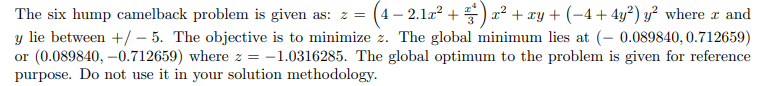

### Optimization Problem Formulation

**Objective**

Minimize the function:

$$
z(x, y) = \left(4 - 2.1x^2 + \frac{x^4}{3}\right)x^2 + xy + \left(-4 + 4y^2\right)y^2
$$

**Mathematical Representation**

Formulate the optimization problem as:

$$
\min_{x, y} z(x, y)
$$

**Subject to the constraints**
$$
x \in [-5, 5], \quad y \in [-5, 5]
$$

**Details**
- $x, y \in \mathbb{R}$: Decision variables to be optimized.
- $z(x, y)$: Objective function describing the six-hump camelback problem.

**Type of Problem**
- Nonlinear programming (NLP) problem.

**Additional Information**

The global minima are at $(-0.089840, 0.712659)$ and $(0.089840, -0.712659)$ with $z_{\text{min}} = -1.0316285$ (to be used for validation, not during optimization).

### Deliverable A
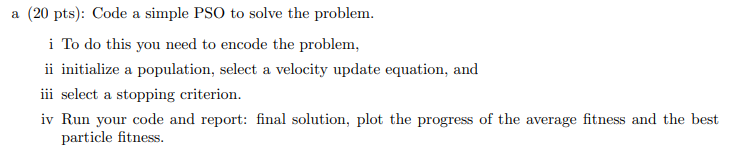

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def objective_function(x, y):
    return (4 - 2.1 * x**2 + (x**4) / 3) * x**2 + x * y + (-4 + 4 * y**2) * y**2

def initialize_particles(num_particles, bounds, vmax):
    positions = np.random.uniform(bounds[0], bounds[1], (num_particles, 2))
    velocities = np.random.uniform(-vmax, vmax, (num_particles, 2))
    return positions, velocities

def update_velocity(velocity, position, personal_best, global_best, w, cog_coeff, soc_coeff):
    r1, r2 = np.random.rand(), np.random.rand()
    inertia = w * velocity
    cognitive = cog_coeff * r1 * (personal_best - position)
    social = soc_coeff * r2 * (global_best - position)
    return inertia + cognitive + social

def clip_particles(positions, velocities, bounds, vmax):
    positions = np.clip(positions, bounds[0], bounds[1])
    velocities = np.clip(velocities, -vmax, vmax)
    return positions, velocities

def pso(num_particles, bounds, max_iter, w, cog_coeff, soc_coeff, vmax):
    positions, velocities = initialize_particles(num_particles, bounds, vmax)
    personal_best_positions = np.copy(positions)
    personal_best_scores = np.array([objective_function(x, y) for x, y in positions])
    global_best_position = positions[np.argmin(personal_best_scores)]
    global_best_score = np.min(personal_best_scores)

    # For tracking performance
    best_scores = []

    for _ in range(max_iter):
        for i in range(num_particles):
            velocities[i] = update_velocity(
                velocities[i], positions[i], personal_best_positions[i], global_best_position, w, cog_coeff, soc_coeff
            )
            positions[i] += velocities[i]

        positions, velocities = clip_particles(positions, velocities, bounds, vmax)

        # Update personal bests
        for i in range(num_particles):
            score = objective_function(positions[i, 0], positions[i, 1])
            if score < personal_best_scores[i]:
                personal_best_scores[i] = score
                personal_best_positions[i] = positions[i]

        # Update global best
        best_particle_idx = np.argmin(personal_best_scores)
        if personal_best_scores[best_particle_idx] < global_best_score:
            global_best_score = personal_best_scores[best_particle_idx]
            global_best_position = personal_best_positions[best_particle_idx]

        best_scores.append(global_best_score)

    return global_best_position, global_best_score, best_scores


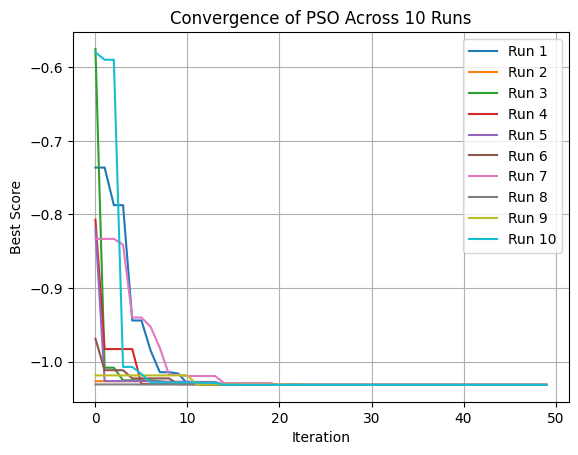

Average Best Score over 10 runs: -1.0316285


In [48]:
# Problem 1 Defaults
bounds = [-5, 5]
num_particles = 30
max_iter = 50
w = 0.6
cog_coeff = 1.7
soc_coeff = 1.7
vmax = 2.0

# Run 10 times to get a better idea of perfomance
all_best_scores = []
final_best_scores = []
for i in range(10):
    best_position, best_score, best_scores = pso(num_particles, bounds, max_iter, w, cog_coeff, soc_coeff, vmax)
    all_best_scores.append(best_scores)
    final_best_scores.append(best_score)
    plt.plot(best_scores, label=f"Run {i+1}")

plt.xlabel("Iteration")
plt.ylabel("Best Score")
plt.title("Convergence of PSO Across 10 Runs")
plt.legend()
plt.grid()
plt.show()

average_best_score = round(np.mean(final_best_scores), 7)
print(f"Average Best Score over 10 runs: {average_best_score}")


#### Results
- The swarm seems to quickly converge on a solution that is equal to the provided global optima.
- This is true after running the algorithm 10 times and taking the average best score of all the runs.

### Deliverable B
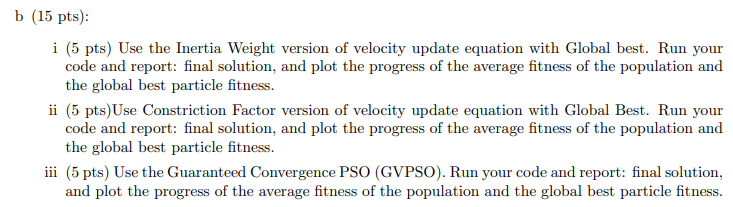

#### Inertia Weight Version
- The implementation in `a)` already uses an inertia weight based velocity update
- Just need to update the `pso` function so that we can properly report on the implementation as per the deliverable.

In [49]:
def pso(num_particles, bounds, max_iter, w, cog_coeff, soc_coeff, vmax):
    positions, velocities = initialize_particles(num_particles, bounds, vmax)
    personal_best_positions = np.copy(positions)
    personal_best_scores = np.array([objective_function(x, y) for x, y in positions])
    global_best_position = positions[np.argmin(personal_best_scores)]
    global_best_score = np.min(personal_best_scores)

    # For tracking performance
    best_scores = []
    all_positions = []
    all_fitness = []

    for _ in range(max_iter):
        current_fitness = np.array([objective_function(x, y) for x, y in positions])
        all_positions.append(np.copy(positions))
        all_fitness.append(current_fitness)

        for i in range(num_particles):
            velocities[i] = update_velocity(
                velocities[i], positions[i], personal_best_positions[i], global_best_position, w, cog_coeff, soc_coeff
            )
            positions[i] += velocities[i]

        positions, velocities = clip_particles(positions, velocities, bounds, vmax)

        # Update personal bests
        for i in range(num_particles):
            score = objective_function(positions[i, 0], positions[i, 1])
            if score < personal_best_scores[i]:
                personal_best_scores[i] = score
                personal_best_positions[i] = positions[i]

        # Update global best
        best_particle_idx = np.argmin(personal_best_scores)
        if personal_best_scores[best_particle_idx] < global_best_score:
            global_best_score = personal_best_scores[best_particle_idx]
            global_best_position = personal_best_positions[best_particle_idx]

        best_scores.append(global_best_score)

    # Convert all_positions and all_fitness to numpy arrays for easier handling
    all_positions = np.array(all_positions)
    all_fitness = np.array(all_fitness)

    return global_best_position, global_best_score, all_positions, all_fitness


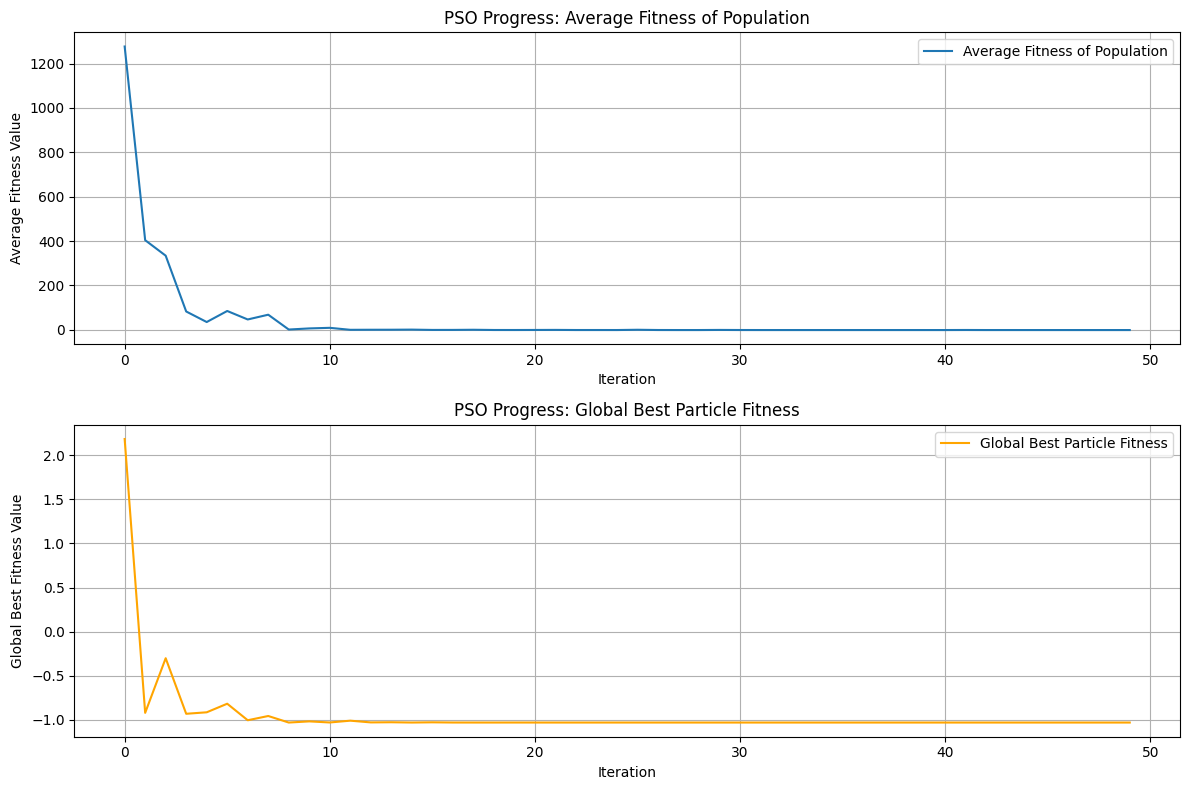

Final Global Best Position: [ 0.0898481 -0.7126631]
Final Global Best Score: -1.0316285


In [50]:
# Problem 1 defaults
bounds = [-5, 5]
num_particles = 30
max_iter = 50
w = 0.6
cog_coeff = 1.7
soc_coeff = 1.7
vmax = 2.0

global_best_position, global_best_score, all_positions, all_fitness = pso(
    num_particles, bounds, max_iter, w, cog_coeff, soc_coeff, vmax
)

def show_problem_2_results(all_fitness, global_best_position, global_best_score):
    # Calculate average fitness and best fitness at each iteration
    average_fitness = np.mean(all_fitness, axis=1)
    global_best_fitness_progress = np.min(all_fitness, axis=1)

    # Create subplots
    plt.figure(figsize=(12, 8))

    # Subplot 1: Average fitness
    plt.subplot(2, 1, 1)
    plt.plot(average_fitness, label="Average Fitness of Population")
    plt.xlabel("Iteration")
    plt.ylabel("Average Fitness Value")
    plt.title("PSO Progress: Average Fitness of Population")
    plt.legend()
    plt.grid()

    # Subplot 2: Global best fitness
    plt.subplot(2, 1, 2)
    plt.plot(global_best_fitness_progress, label="Global Best Particle Fitness", color="orange")
    plt.xlabel("Iteration")
    plt.ylabel("Global Best Fitness Value")
    plt.title("PSO Progress: Global Best Particle Fitness")
    plt.legend()
    plt.grid()

    # Show the figure
    plt.tight_layout()
    plt.show()

    # Print final results
    print(f"Final Global Best Position: {np.round(global_best_position, 7)}")
    print(f"Final Global Best Score: {np.round(global_best_score, 7)}")

show_problem_2_results(all_fitness, global_best_position, global_best_score)


#### Constriction Factor Version
- Just going to re-define the velocity update function.

In [51]:
def update_velocity(velocity, position, personal_best, global_best, w, cog_coeff, soc_coeff):
    r1, r2 = np.random.rand(), np.random.rand()
    # inertia = w * velocity
    phi = cog_coeff + soc_coeff
    kappa = 2 / abs(2 - phi - (phi ** 2 - 4 * phi) ** 0.5)
    cognitive = cog_coeff * r1 * (personal_best - position)
    social = soc_coeff * r2 * (global_best - position)
    return kappa * (velocity + cognitive + social)

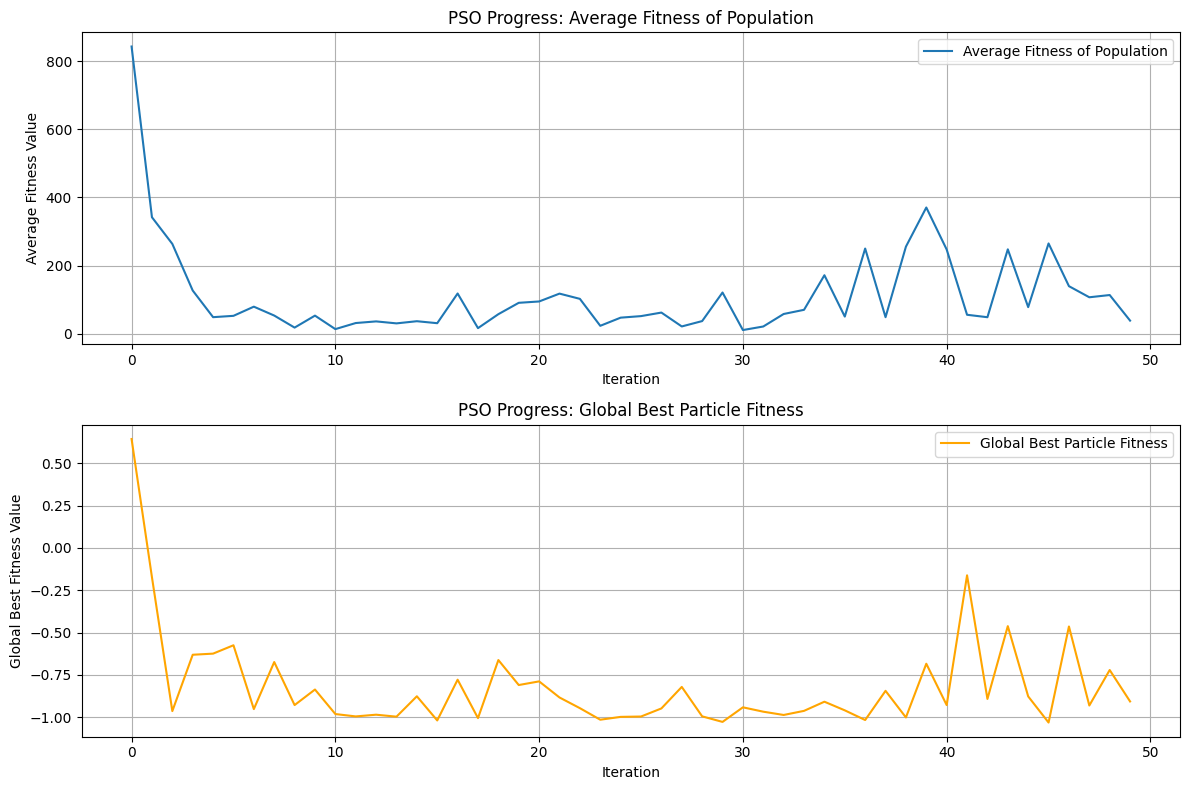

Final Global Best Position: [ 0.0905277 -0.7124037]
Final Global Best Score: -1.0316259


In [52]:
bounds = [-5, 5]
num_particles = 30
max_iter = 50
w = 0.6
cog_coeff = 1.7
soc_coeff = 1.7
vmax = 2.0

global_best_position, global_best_score, all_positions, all_fitness = pso(
    num_particles, bounds, max_iter, w, cog_coeff, soc_coeff, vmax
)

show_problem_2_results(all_fitness, global_best_position, global_best_score)

* Need `phi = cog_coeff + soc_coeff` > 4 for solution stability

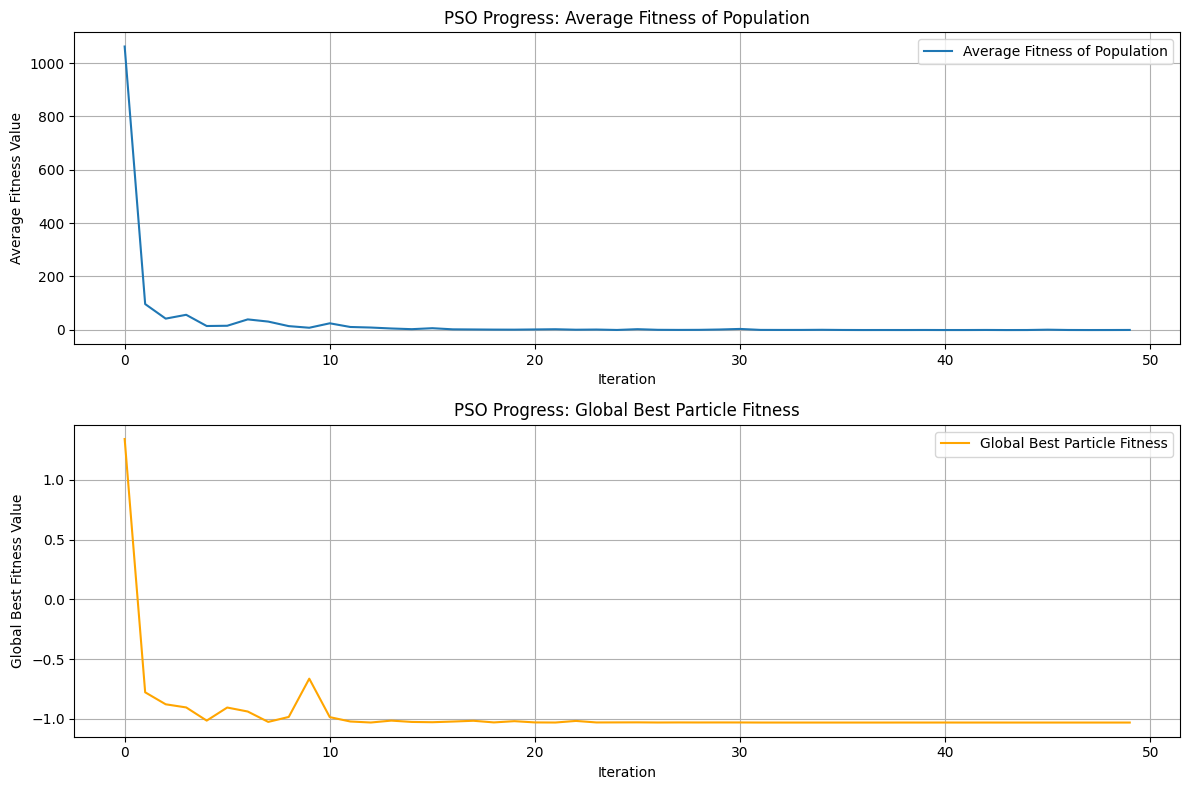

Final Global Best Position: [ 0.0896484 -0.712724 ]
Final Global Best Score: -1.0316283


In [53]:
bounds = [-5, 5]
num_particles = 30
max_iter = 50
w = 0.6
cog_coeff = 2.05
soc_coeff = 2.05
vmax = 2.0

global_best_position, global_best_score, all_positions, all_fitness = pso(
    num_particles, bounds, max_iter, w, cog_coeff, soc_coeff, vmax
)

show_problem_2_results(all_fitness, global_best_position, global_best_score)

#### Guarenteed Convergence PSO
- To implement, want to add randomness to the inerta that decays overtime.
- The randomness helps prevent the algorithm from getting stuck in local minima while the decay helps it converge as the algorithm progresses.
- Just need to update the original implementation of `pso` to do this

In [54]:
# Want this back to the inertia version
def update_velocity(velocity, position, personal_best, global_best, w, cog_coeff, soc_coeff):
    r1, r2 = np.random.rand(), np.random.rand()
    inertia = w * velocity
    cognitive = cog_coeff * r1 * (personal_best - position)
    social = soc_coeff * r2 * (global_best - position)
    return inertia + cognitive + social


def pso(num_particles, bounds, max_iter, w_min, w_max, cog_coeff, soc_coeff, vmax):
    positions, velocities = initialize_particles(num_particles, bounds, vmax)
    personal_best_positions = np.copy(positions)
    personal_best_scores = np.array([objective_function(x, y) for x, y in positions])
    global_best_position = positions[np.argmin(personal_best_scores)]
    global_best_score = np.min(personal_best_scores)

    # For tracking performance
    best_scores = []
    all_positions = []
    all_fitness = []

    # For decaying the inertia weight
    w_delta = w_max - w_min

    for iteration in range(max_iter):
        current_fitness = np.array([objective_function(x, y) for x, y in positions])
        all_positions.append(np.copy(positions))
        all_fitness.append(current_fitness)

        # Decay the the inertia weight
        w_max_d = w_max - w_delta * (iteration / max_iter) 
        if w_max_d < w_min:
            w_max_d = w_min
        # Randomly sample inertia weight
        w = np.random.uniform(w_min, w_max_d)

        for i in range(num_particles):
            velocities[i] = update_velocity(
                velocities[i], positions[i], personal_best_positions[i], global_best_position, w, cog_coeff, soc_coeff
            )
            positions[i] += velocities[i]

        positions, velocities = clip_particles(positions, velocities, bounds, vmax)

        # Update personal bests
        for i in range(num_particles):
            score = objective_function(positions[i, 0], positions[i, 1])
            if score < personal_best_scores[i]:
                personal_best_scores[i] = score
                personal_best_positions[i] = positions[i]

        # Update global best
        best_particle_idx = np.argmin(personal_best_scores)
        if personal_best_scores[best_particle_idx] < global_best_score:
            global_best_score = personal_best_scores[best_particle_idx]
            global_best_position = personal_best_positions[best_particle_idx]

        best_scores.append(global_best_score)

    # Convert all_positions and all_fitness to numpy arrays for easier handling
    all_positions = np.array(all_positions)
    all_fitness = np.array(all_fitness)

    return global_best_position, global_best_score, all_positions, all_fitness

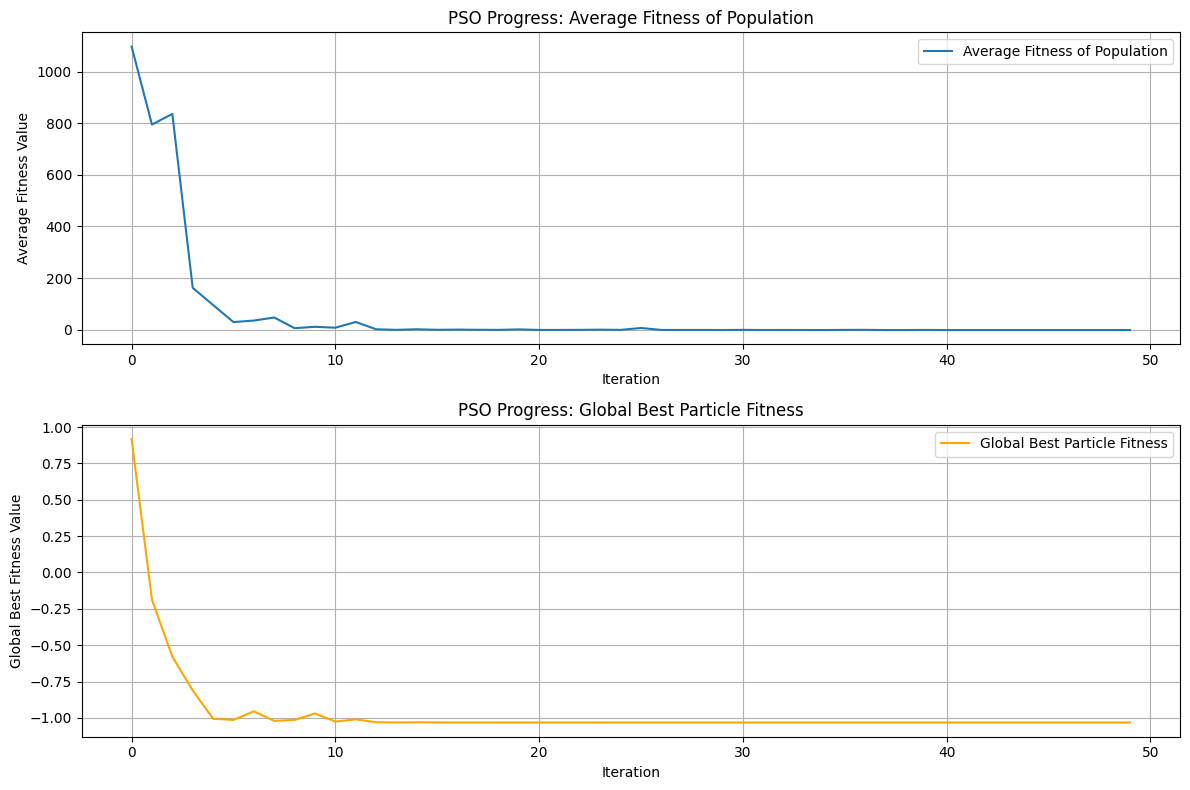

Final Global Best Position: [-0.0898424  0.7126581]
Final Global Best Score: -1.0316285


In [55]:
bounds = [-5, 5]
num_particles = 30
max_iter = 50
w_min = 0.4  # Minimum inertia weight
w_max = 0.9  # Maximum inertia weight
cog_coeff = 1.7
soc_coeff = 1.7
vmax = 2.0

global_best_position, global_best_score, all_positions, all_fitness = pso(
    num_particles, bounds, max_iter, w_min, w_max, cog_coeff, soc_coeff, vmax
)

show_problem_2_results(all_fitness, global_best_position, global_best_score)